In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

     |████████████████████████████████| 66.1MB 92kB/s 


In [ ]:
!pip install petroeval
import petroeval as pet
from petroeval import evaluate_reservoir
from petroeval import log_plot, three_plots
from petroeval import FormationEvaluation, preprocessing
from petroeval import visualizations
from petroeval.visualizations import summary

In [ ]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
 
  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

In [ ]:
A = np.load('/content/drive/My Drive/FORCE-Lithology-Prediction/penalty_matrix.npy')
 
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]
 
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(24,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [ ]:
#importing files
train = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/train1.csv')
test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
valid1 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid4.csv')
valid2 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid5.csv')
valid3 = pd.concat((valid1, valid2)).reset_index(drop=True)
 
ntrain = train.shape[0]
ntest = test.shape[0]
nvalid1 = valid1.shape[0]
nvalid2 = valid2.shape[0]
nvalid3 = valid3.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test, valid1, valid2, valid3)).reset_index(drop=True)

In [ ]:
df['LITHO'] = None
df.loc[df.GR < 64, 'LITHO'] = 'ss'
df.loc[df.GR > 98, 'LITHO'] = 'sh'
df.loc[(df.GR >= 64) & (df.GR <= 98), 'LITHO'] = 'ssh'
df.LITHO.value_counts()

ss     699066
ssh    578041
sh     235736
Name: LITHO, dtype: int64

In [ ]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [ ]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 
        'DTS', 'RXO', 'DRHO', 'ROPA', 'RMIC', 'RSHA', 'MUDWEIGHT', 'ROP', 'PEF', 'BS', 'DCAL']
df = drop_columns(df, *cols)
print(df.shape)

(1512843, 29)
(1512843, 16)


In [ ]:
df = freq_encode(df, ['FORMATION', 'GROUP'])
print(df.shape)
df = mean_target(df, ['FORMATION', 'GROUP'])
df.shape

(1500138, 21)


(1500138, 23)

In [ ]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
#df['LITHO_encoded'] = df['LITHO'].astype('category')
#df['LITHO_encoded'] = df['LITHO_encoded'].cat.codes
df.shape

(1512843, 18)

In [ ]:
col = ['GROUP']
 
df = one_hot_encoding(df, *col)
df.shape

(1500138, 32)

In [ ]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation1 = validation1.reset_index(drop=True)
 
validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation2 = validation2.reset_index(drop=True)
 
 
validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape, validation1.shape, valid1.shape, validation2.shape, validation3.shape, valid2.shape)

(964965, 14) (136786, 14) (114079, 14) (114079, 29) (91467, 14) (205546, 14) (91467, 29)


In [ ]:
traindata = train2
testdata = test2
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler().fit(traindata)
def scale_data(data):
  
  data = scaler.transform(data)
  #testdata = scaler.transform(testdata)
  data = pd.DataFrame(data, columns=testdata.columns)
 
  return data

In [ ]:
traindata = scale_data(traindata)
testdata = scale_data(testdata)
validation1 = scale_data(validation1)
validation2 = scale_data(validation2)
validation3 = scale_data(validation3)

In [ ]:
traindata.sort_index(inplace=True)

In [ ]:
lithology1 = pd.DataFrame(lithology)
lithology1.sort_index(inplace=True)
#lithology1

In [ ]:
#ytrain2

In [ ]:
#train2

In [ ]:
train1 = traindata.iloc[:100000]
train2 = traindata.iloc[100000:200000]
train3 = traindata.iloc[200000:300000]
train4 = traindata.iloc[300000:400000]
train5 = traindata.iloc[400000:]
#train6 = traindata.iloc[500000:600000]
#train7 = traindata.iloc[600000:700000]
#train8 = traindata.iloc[700000:]
 
train1.shape, train5.shape#, train7.shape

((100000, 14), (178979, 14))

In [ ]:
ytrain1 = lithology1.iloc[:100000]
ytrain2 = lithology1.iloc[100000:200000]
ytrain3 = lithology1.iloc[200000:300000]
ytrain4 = lithology1.iloc[300000:400000]
ytrain5 = lithology1.iloc[400000:]
#ytrain6 = lithology1.iloc[500000:600000]
#ytrain7 = lithology1.iloc[600000:700000]
#ytrain8 = lithology1.iloc[700000:]
 
ytrain1.shape, ytrain2.shape, ytrain5.shape

((100000, 1), (100000, 1), (178979, 1))

In [ ]:
validation, traindata, valid_target, lithology = ms.train_test_split(traindata, lithology, random_state=405, test_size=0.6, stratify=lithology)
print(validation.shape, valid_target.shape, traindata.shape, lithology.shape)

(385986, 14) (385986,) (578979, 14) (578979,)


In [ ]:
train1, sample1, ytrain1, ysample1 = ms.train_test_split(traindata, lithology, random_state=405, test_size=0.8, stratify=lithology)
print(train1.shape, ytrain1.shape, sample1.shape)

(115795, 14) (115795,) (463184, 14)


In [ ]:
train2, sample2, ytrain2, ysample2 = ms.train_test_split(sample1, ysample1, random_state=405, test_size=0.75, stratify=ysample1)
print(train2.shape, ytrain2.shape, sample2.shape)

(115796, 14) (115796,) (347388, 14)


In [ ]:
train3, train4, ytrain3, ytrain4 = ms.train_test_split(sample2, ysample2, random_state=405, test_size=0.666666667, stratify=ysample2)
print(train3.shape, ytrain3.shape, train4.shape, ytrain4.shape)

(115795, 14) (115795,) (231593, 14) (231593,)


In [ ]:
train5, train4, ytrain5, ytrain4 = ms.train_test_split(train4, ytrain4, random_state=405, test_size=0.5, stratify=ytrain4)
print(train5.shape, ytrain5.shape, train4.shape, ytrain4.shape)

(115796, 14) (115796,) (115797, 14) (115797,)


In [ ]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      #self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                  # pd.DataFrame(np.array(self.train_label)), 
                                                                                   #test_size=0.2,
                                                                                   #random_state=212)
      #self.x_train = self.train.iloc[:700000]
      #self.x_test = self.train.iloc[700000:]
      #self.y_train = pd.DataFrame(self.train_label).iloc[:700000]
      #self.y_test = pd.DataFrame(self.train_label).iloc[700000:]
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 5
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      model = CatBoostClassifier(n_estimators=100000, random_state=2020, learning_rate=0.1,
                                 use_best_model=True, max_depth=8,
                                 eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      #model = XGBClassifier(n_estimators=100000, max_depth=10,
                            #objective='multi:softprob', learning_rate=0.033,
                            #subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            #eval_metric='mlogloss', verbose=2020)
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=200, eval_set=[(X_test, Y_test)], verbose=1000)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(self.validation1)
        prediction = model.predict(self.validation2)
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(self.validation1)
        val2 += model.predict_proba(self.validation2)
        val3 += model.predict_proba(self.validation3)
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
class Model():
    
    def __init__(self, train, test, open_test, open_test1, validation, train_label, test_label, test_label1):
        
        
        self.train = train
        self.test = test
        self.open_test = open_test
        self.open_test1 = open_test1
        self.validation = validation
        self.train_label = train_label
        self.test_label = test_label
        self.test_label1 = test_label1
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=212)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      
      #model = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', max_depth=20, verbose=2)
      model = XGBClassifier(n_estimators=10000, max_depth=10, reg_lambda=20,
                            objective='multi:softmax', learning_rate=0.033,
                            subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020)
      
      model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2, random_state=30)
 
      #model = CatBoostClassifier(n_estimators=20, random_state=3030, learning_rate=0.1,
                                 #use_best_model=True, max_depth=4,
                                 #eval_metric='MultiClass', task_type='CPU', verbose=100)
 
 
      
      model.fit(self.train, self.train_label)
      #model.fit(self.x_train, self.y_train, early_stopping_rounds=100, eval_set=[(self.x_test, self.y_test)], verbose=100)
      pred = model.predict_proba(self.test)      
      open_pred = model.predict_proba(self.open_test)
      open_pred1 = model.predict_proba(self.open_test1)
      val = model.predict_proba(self.validation)
        
 
      print('----------------TEST EVALUATION------------------')
      print(show_evaluation(open_pred, self.test_label))
      print(show_evaluation(open_pred1, self.test_label1))
                  
      if plot: self.plot_feat_imp(model)
      return pred, open_pred, open_pred1, val, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(30,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
traindata.columns

In [ ]:
func1_= Model(train1, validation, validation1, validation2, validation3, ytrain1, valid1_lithology, valid2_lithology)
pred1, val1, open_test1, open_test11, model1 = func1_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


----------------TEST EVALUATION------------------
Default score: [-2.76868442 -2.76868442 -2.76329999 -2.76868442 -2.76868442 -2.7686888
 -2.76868442 -2.76868442 -2.76868442 -2.76868442 -2.76868442 -2.76868442]


ValueError: ignored

In [ ]:
func2_= Model(train2, validation, validation1, validation2, validation3, ytrain2, valid1_lithology, valid2_lithology)
pred2, val2, open_test2, open_test22, model2 = func2_()

In [ ]:
func3_= Model(train3, validation, validation1, validation2, validation3, ytrain3, valid1_lithology, valid2_lithology)
pred3, val3, open_test3, open_test33, model3 = func3_()

In [ ]:
func4_= Model(train4, validation, validation1, validation2, validation3, ytrain4, valid1_lithology, valid2_lithology)
pred4, val4, open_test4, open_test44, model4 = func4_()

In [ ]:
func5_= Model(train5, validation, validation1, validation2, validation3, ytrain5, valid1_lithology, valid2_lithology)
pred5, val5, open_test5, open_test55, model5 = func5_()

In [ ]:
class Model():
    
    def __init__(self, train, test, open_test, open_test1, validation, train_label, test_label, test_label1):
        
        
        self.train = train
        self.test = test
        self.open_test = open_test
        self.open_test1 = open_test1
        self.validation = validation
        self.train_label = train_label
        self.test_label = test_label
        self.test_label1 = test_label1
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=212)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=22, verbose=2)
      #model = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', max_depth=20, verbose=2)
      model = XGBClassifier(n_estimators=10000, max_depth=10, reg_lambda=30,
                            objective='multi:softmax', learning_rate=0.033,
                            subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020)
 
      #model = CatBoostClassifier(n_estimators=20, random_state=3030, learning_rate=0.1,
                                 #use_best_model=True, max_depth=4,
                                 #eval_metric='MultiClass', task_type='CPU', verbose=100)
 
 
      
      #model.fit(self.train, self.train_label)
      model.fit(self.x_train, self.y_train, early_stopping_rounds=100, eval_set=[(self.x_test, self.y_test)], verbose=100)
      pred = model.predict(self.test)      
      open_pred = model.predict(self.open_test)
      open_pred1 = model.predict(self.open_test1)
      val = model.predict(self.validation)
        
 
      print('----------------TEST EVALUATION------------------')
      print(show_evaluation(open_pred, self.test_label))
      print(show_evaluation(open_pred1, self.test_label1))
                  
      if plot: self.plot_feat_imp(model)
      return pred, open_pred, open_pred1, val, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(30,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
for i,j in enumerate(train1.columns):
    print(i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RMED
6 RDEP
7 RHOB
8 GR
9 NPHI
10 PEF
11 DTC
12 SP
13 BS
14 DRHO
15 GROUP_BAAT GP.
16 GROUP_BOKNFJORD GP.
17 GROUP_CROMER KNOLL GP.
18 GROUP_DUNLIN GP.
19 GROUP_HEGRE GP.
20 GROUP_HORDALAND GP.
21 GROUP_NORDLAND GP.
22 GROUP_ROGALAND GP.
23 GROUP_ROTLIEGENDES GP.
24 GROUP_SHETLAND GP.
25 GROUP_TYNE GP.
26 GROUP_VESTLAND GP.
27 GROUP_VIKING GP.
28 GROUP_ZECHSTEIN GP.


[0]	validation_0-mlogloss:2.36832
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.50636
[200]	validation_0-mlogloss:0.366956
[300]	validation_0-mlogloss:0.323344
[400]	validation_0-mlogloss:0.300713
[500]	validation_0-mlogloss:0.285859
[600]	validation_0-mlogloss:0.275687
[700]	validation_0-mlogloss:0.268136
[800]	validation_0-mlogloss:0.262334
[900]	validation_0-mlogloss:0.257521
[1000]	validation_0-mlogloss:0.253785
[1100]	validation_0-mlogloss:0.250565
[1200]	validation_0-mlogloss:0.247941
[1300]	validation_0-mlogloss:0.24568
[1400]	validation_0-mlogloss:0.243788
[1500]	validation_0-mlogloss:0.242189
[1600]	validation_0-mlogloss:0.240815
[1700]	validation_0-mlogloss:0.239652
[1800]	validation_0-mlogloss:0.23864
[1900]	validation_0-mlogloss:0.237847
[2000]	validation_0-mlogloss:0.237106
[2100]	validation_0-mlogloss:0.23652
[2200]	validation_0-mlogloss:0.236098
[2300]	validation_0-mlogloss:0.235718
[2400]	validation_0-mlogloss:0.2354

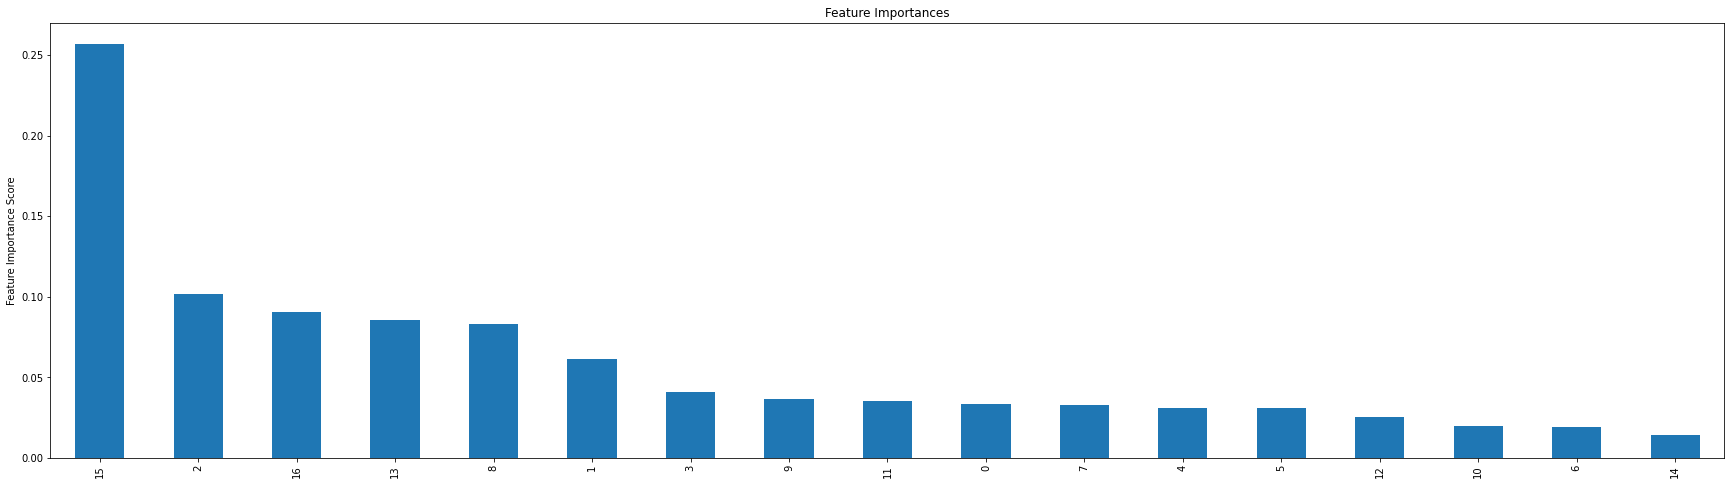

In [ ]:
func4_= Model(train4, validation, validation1, validation2, validation3, ytrain4, valid1_lithology, valid2_lithology)
pred4, val4, open_test4, open_test44, model4 = func4_()  #max-depth=6, gamma=50

In [ ]:
func5_= Model(train5, validation, validation1, validation2, validation3, ytrain5, valid1_lithology, valid2_lithology)
pred5, val5, open_test5, open_test55, model5 = func5_()   #max-depth=4, gamma=100

[0]	validation_0-mlogloss:2.36059
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.441665
[200]	validation_0-mlogloss:0.311872
[300]	validation_0-mlogloss:0.275655
[400]	validation_0-mlogloss:0.258251
[500]	validation_0-mlogloss:0.24808
[600]	validation_0-mlogloss:0.241141
[700]	validation_0-mlogloss:0.23645
[800]	validation_0-mlogloss:0.232931
[900]	validation_0-mlogloss:0.230312
[1000]	validation_0-mlogloss:0.228279
[1100]	validation_0-mlogloss:0.226733
[1200]	validation_0-mlogloss:0.225637
[1300]	validation_0-mlogloss:0.224838
[1400]	validation_0-mlogloss:0.224361
[1500]	validation_0-mlogloss:0.224124
[1600]	validation_0-mlogloss:0.224164
Stopping. Best iteration:
[1536]	validation_0-mlogloss:0.22407

----------------TEST EVALUATION------------------
Default score: -0.6793737849226792
Accuracy is: 0.7451125519337616
F1 is: 0.7562190929194389
None
Default score: -0.9153111681783411
Accuracy is: 0.6427712818271227
F1 is: 0.71350831302

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


----------------TEST EVALUATION------------------
Default score: -0.6430532788681528
Accuracy is: 0.7555027656273284
F1 is: 0.7796439527514178
None
Default score: -0.5867990641433523
Accuracy is: 0.7828725113975532
F1 is: 0.8067187452422184
None


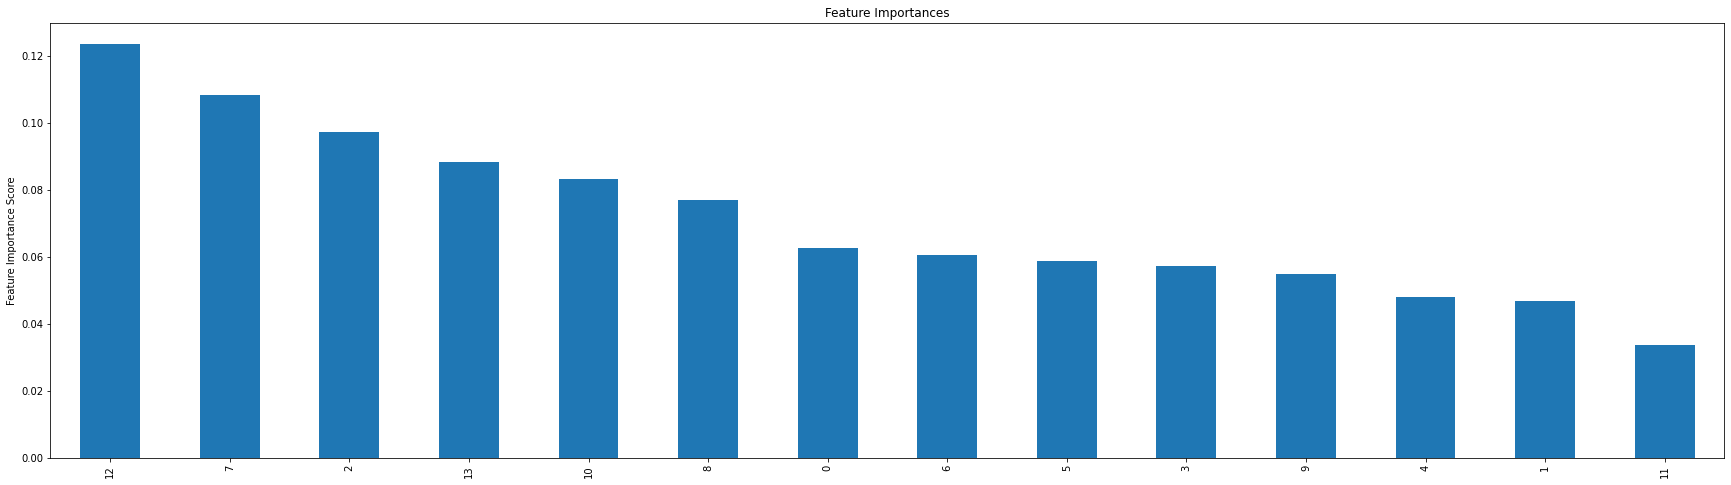

In [ ]:
func6_= Model(train1, validation, validation1, validation2, validation3, ytrain1, valid1_lithology, valid2_lithology)
pred6, val6, open_test6, open_test66, model6 = func6_()  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


----------------TEST EVALUATION------------------
Default score: -0.6372491869669265
Accuracy is: 0.7571858098335364
F1 is: 0.7804755836870215
None
Default score: -0.5610807723003924
Accuracy is: 0.7877376540172959
F1 is: 0.8005691698187195
None


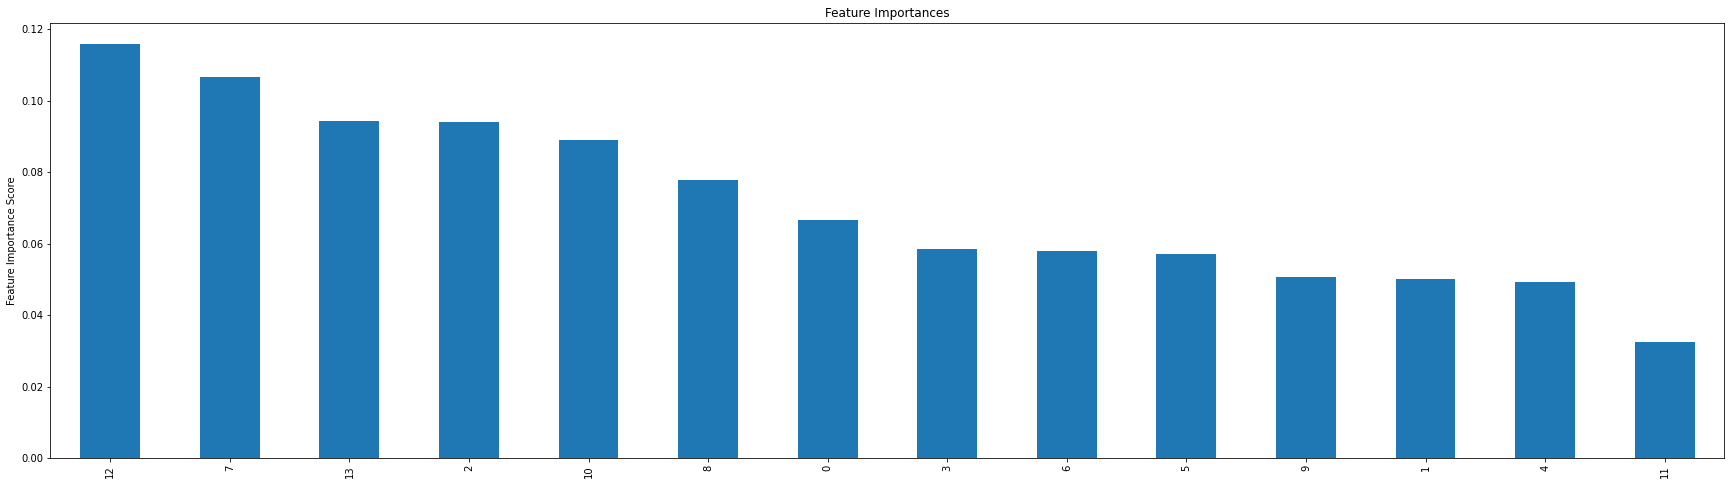

In [ ]:
func7_= Model(train2, validation, validation1, validation2, validation3, ytrain2, valid1_lithology, valid2_lithology)
pred7, val7, open_test7, open_test77, model7 = func7_() 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


----------------TEST EVALUATION------------------
Default score: -0.6627786446234627
Accuracy is: 0.7464739347294419
F1 is: 0.7734938514756174
None
Default score: -0.5825201985415505
Accuracy is: 0.781626160254518
F1 is: 0.805426572055224
None


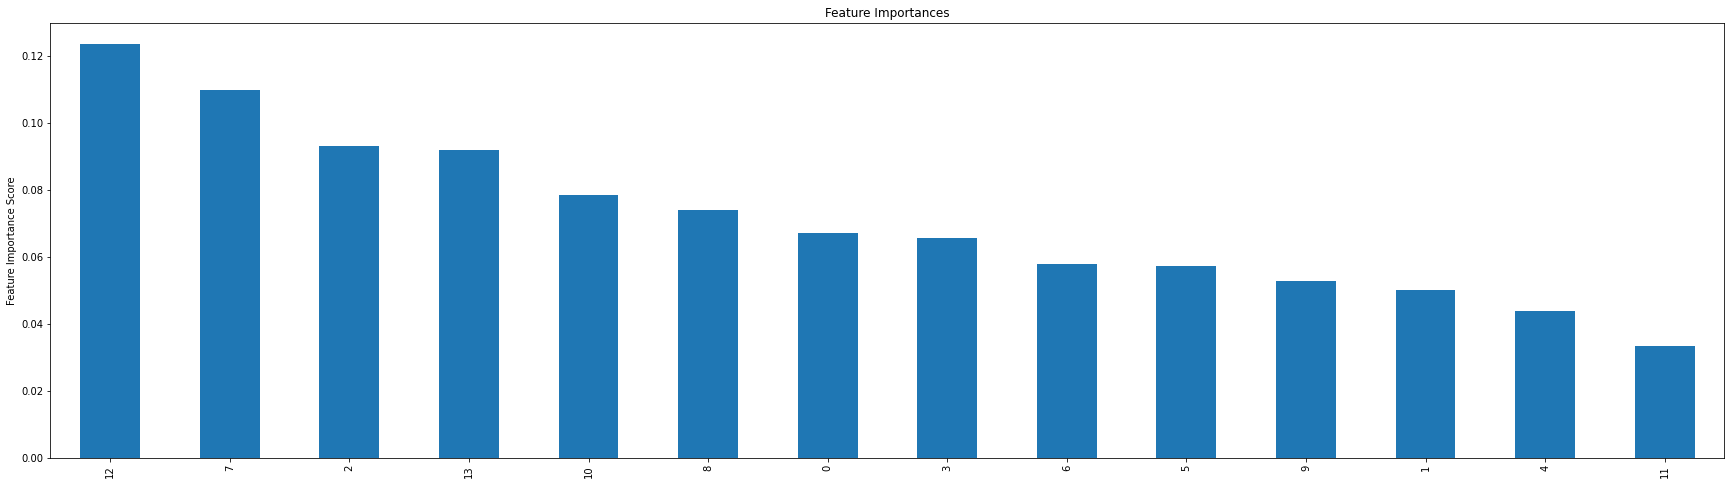

In [ ]:
func8_= Model(train3, validation, validation1, validation2, validation3, ytrain3, valid1_lithology, valid2_lithology)
pred8, val8, open_test8, open_test88, model8 = func8_() 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


----------------TEST EVALUATION------------------
Default score: -0.648185687111563
Accuracy is: 0.7510409453098291
F1 is: 0.7781302287371177
None
Default score: -0.5953595285731466
Accuracy is: 0.7796473044923306
F1 is: 0.80291897135
None


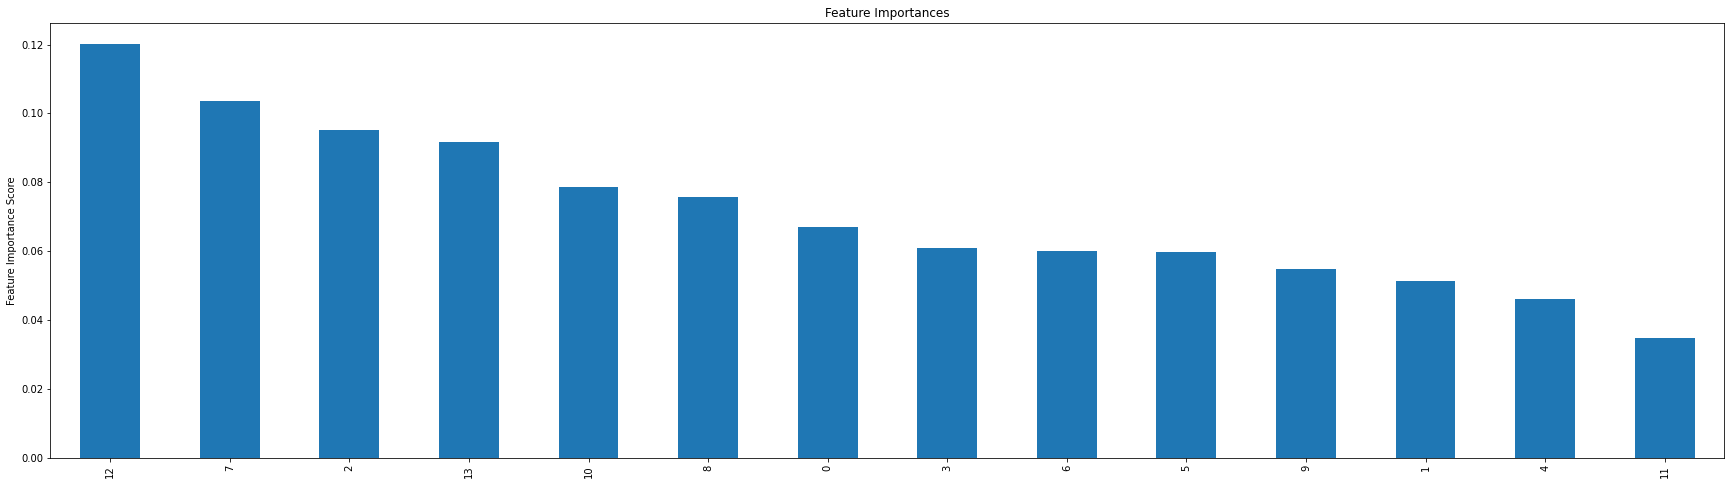

In [ ]:
func9_= Model(train4, validation, validation1, validation2, validation3, ytrain4, valid1_lithology, valid2_lithology)
pred9, val9, open_test9, open_test99, model9 = func9_()  #max-depth=5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


----------------TEST EVALUATION------------------
Default score: -0.6622625548961685
Accuracy is: 0.7450451003252132
F1 is: 0.7768047509886961
None
Default score: -0.5762720434692293
Accuracy is: 0.7855948046836564
F1 is: 0.8064451028352332
None


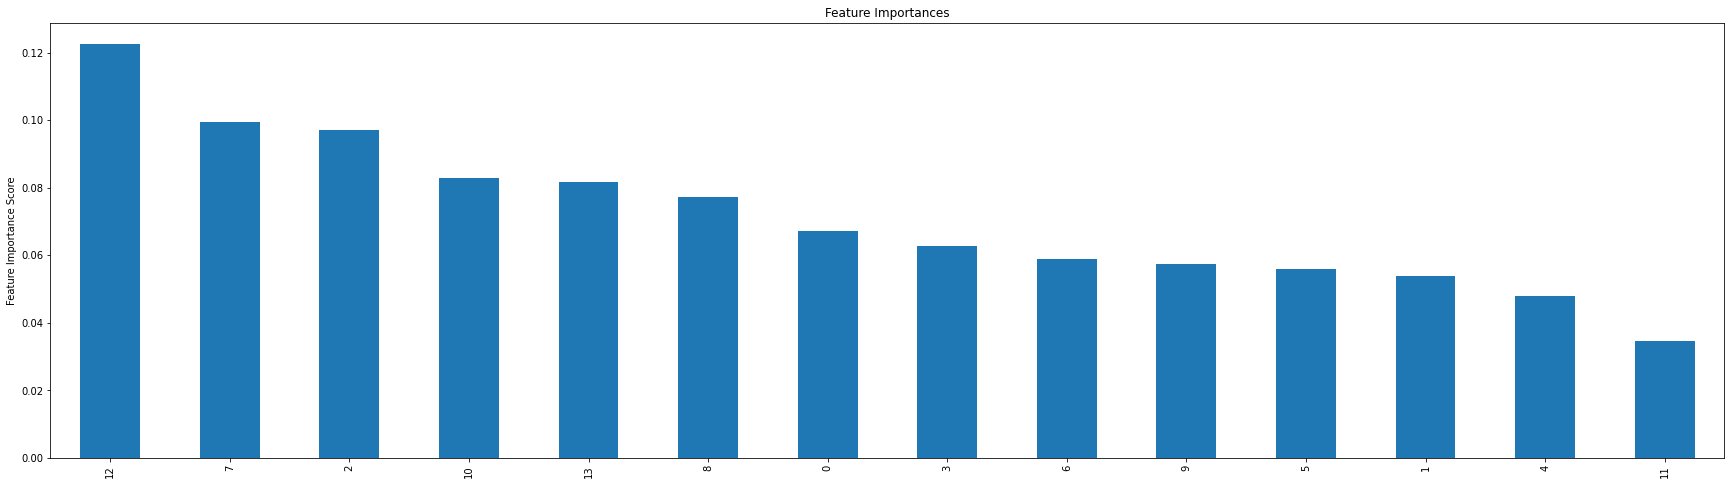

In [ ]:
func10_= Model(train5, validation, validation1, validation2, validation3, ytrain5, valid1_lithology, valid2_lithology)
pred10, val10, open_test10, open_test110, model10 = func10_()  #max-depth=6

In [ ]:
for (i, j) in enumerate(train5.columns):
  print(i, j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RMED
6 RDEP
7 RHOB
8 GR
9 NPHI
10 DTC
11 SP
12 GROUP_encoded
13 FORMATION_encoded
14 LITHO_encoded


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


----------------TEST EVALUATION------------------
Default score: -0.6446234626881372
Accuracy is: 0.7550294094443324
F1 is: 0.7771409988250183
None
Default score: -0.5789888703029508
Accuracy is: 0.7861305170170663
F1 is: 0.8090973438480769
None


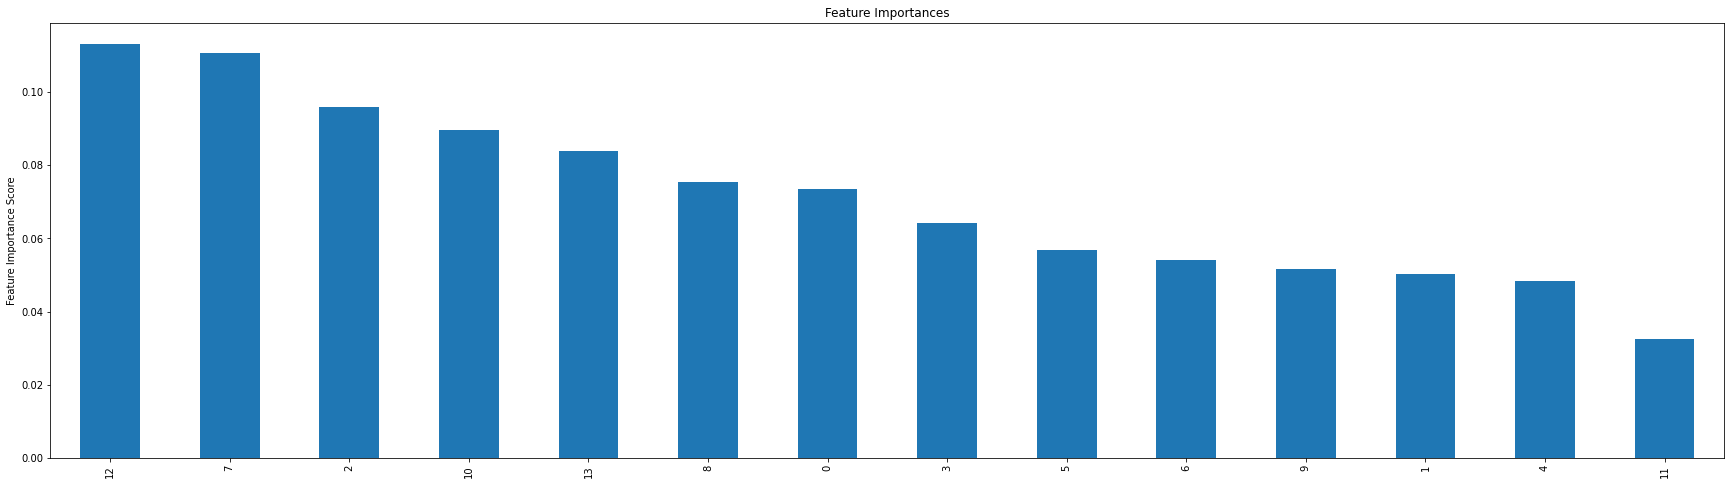

In [ ]:
func11_= Model(train1, validation, validation1, validation2, validation3, ytrain1, valid1_lithology, valid2_lithology)
pred11, val11, open_test11a, open_test111, model11 = func11_()  #max-depth=6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


----------------TEST EVALUATION------------------
Default score: -0.6498961246153981
Accuracy is: 0.7511636672831985
F1 is: 0.7745747047967058
None
Default score: -0.5824149693332021
Accuracy is: 0.7835503514928881
F1 is: 0.8042882956973216
None


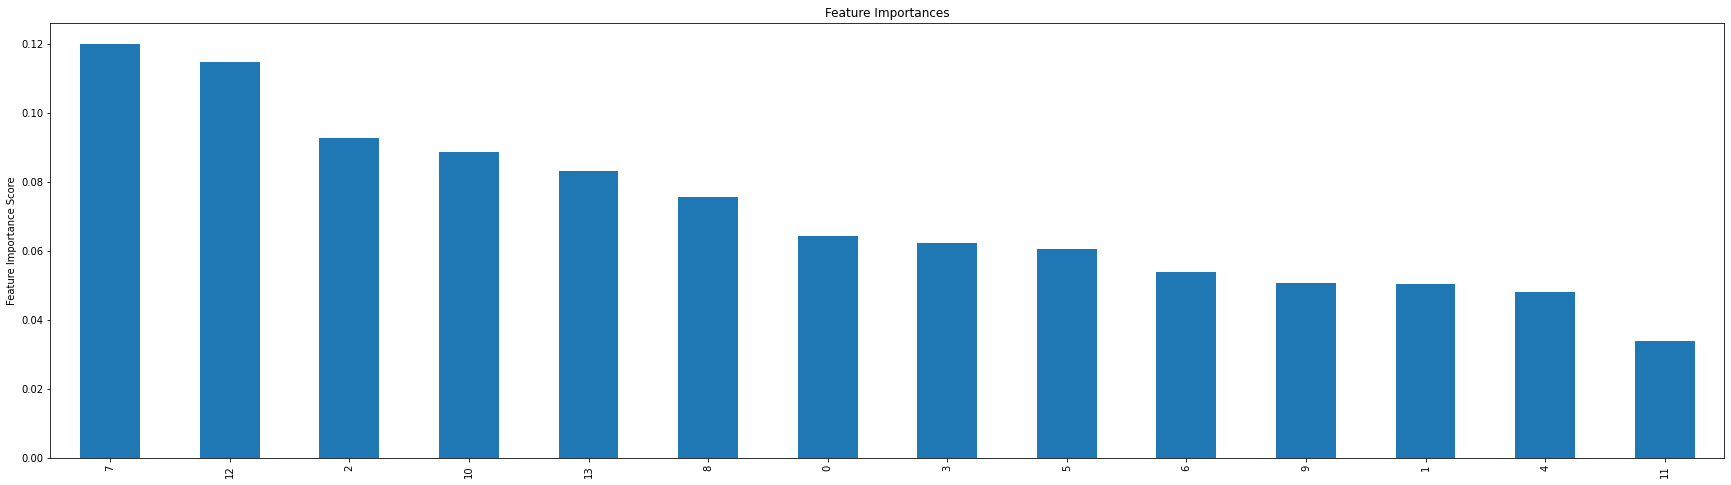

In [ ]:
func12_= Model(train2, validation, validation1, validation2, validation3, ytrain2, valid1_lithology, valid2_lithology)
pred12, val12, open_test12, open_test112, model12 = func12_()  #max-depth=6

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8, val9, val10))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5, open_test6, open_test7, open_test8, open_test9, open_test10))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33, open_test44, open_test55, open_test66, open_test77, open_test88, open_test99, open_test110))

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5))
stack_p = np.column_stack((val1, val2, val3, val4, val5))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33, open_test44, open_test55))

In [ ]:
open_test77.shape, open_test66.shape, open_test55.shape, open_test44.shape, open_test11/shapeopen_test111.shape, open_test112.shape, open_test110.shape, open_test99.shape, open_test88.shape

((192841,), (192841,), (192841,), (192841,), (192841,))

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10, pred11, pred12,
                         pred13, pred14, pred15, pred16, pred17, pred18, pred19, pred20, pred21, pred22, pred23, pred24))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12,
                           val13, val14, val15, val16, val17, val18, val19, val20, val21, val22, val23, val24))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5, open_test6, open_test7, open_test8, open_test9, open_test10, open_test11a, open_test12,
                              open_test13, open_test14, open_test15, open_test16, open_test17, open_test18, open_test19, open_test20, open_test21, open_test22a, open_test23, open_test24))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33, open_test44, open_test55, open_test66, open_test77, open_test88, open_test99, open_test110, open_test111, open_test112,
                               open_test113, open_test114, open_test115, open_test116, open_test117, open_test118, open_test99, open_test110, open_test111, open_test112))

In [ ]:
 
nr.seed(33)
pd.DataFrame(stack_open).sample(50)

,0,1,2,3,4
61588,5,5,5,0,5
32912,2,2,2,2,2
66937,2,2,2,2,2
21929,2,2,2,2,2
27053,2,2,1,0,2
57157,2,2,2,2,2
28521,2,2,0,0,0
53182,5,5,5,0,2
64435,2,2,2,2,1
54924,2,2,2,2,2


In [ ]:
 
nr.seed(33)
pd.DataFrame(valid2_lithology).sample(50)

,FORCE_2020_LITHOFACIES_LITHOLOGY
61588,5
32912,2
66937,2
21929,9
27053,0
57157,2
28521,0
53182,6
64435,1
54924,2


In [ ]:
meta_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', verbose=2)
meta_model.fit(stack, valid_target)
final_open_pred1 = meta_model.predict(stack_p)
final_open_pred11 = meta_model.predict(stack_open)
final_open_pred111 = meta_model.predict(stack_open1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


In [ ]:
meta_model = ExtraTreesClassifier(n_estimators=50, random_state=42, class_weight='balanced', verbose=2)
meta_model.fit(stack, valid_target)
final_open_pred2 = meta_model.predict(stack_p)
final_open_pred22 = meta_model.predict(stack_open)
final_open_pred222 = meta_model.predict(stack_open1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


In [ ]:
meta_model = XGBClassifier(n_estimators=300, max_depth=7, 
                      objective='multi:softmax', learning_rate=0.1,
                      subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                      eval_metric='mlogloss', verbose=2020)
meta_model.fit(stack, valid_target, verbose=50)
final_open_pred3 = meta_model.predict(stack_p)
final_open_pred33 = meta_model.predict(stack_open)
final_open_pred333 = meta_model.predict(stack_open1)

In [ ]:
new_stack = np.column_stack((pred1, pred2, pred4))
new_stack_p = np.column_stack((final_open_pred1, final_open_pred2, final_open_pred3))
new_stack_open = np.column_stack((final_open_pred11, final_open_pred22, final_open_pred33))
new_stack_open1 = np.column_stack((final_open_pred111, final_open_pred222, final_open_pred333))

In [ ]:
pd.DataFrame(new_stack_p).head(50)

,0,1,2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


In [ ]:
pd.DataFrame(valid1_lithology).head(50)

,FORCE_2020_LITHOFACIES_LITHOLOGY
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [ ]:
meta_model = LogisticRegression()
#meta_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', verbose=2)
meta_model.fit(new_stack, valid_target)
#final_val_pred = meta_model.predict(stack_p)
final_open_pred = meta_model.predict(new_stack_p)
final_open_pred1 = meta_model.predict(new_stack_open)
final_open_pred11 = meta_model.predict(new_stack_open1) 
#print(show_evaluation(final_val_pred, valid2_lithology))

NameError: ignored

In [ ]:
meta_model = LogisticRegression()
meta_model = RandomForestClassifier(n_estimators=100, random_state=790, max_depth=11, class_weight='balanced')
meta_model.fit(stack, valid_target)
#final_val_pred = meta_model.predict(stack_p)
final_open_pred = meta_model.predict(stack_p)
final_open_pred1 = meta_model.predict(stack_open)
final_open_pred11 = meta_model.predict(stack_open1)

In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))   #8xgboost stacks
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.6499531026744624
Accuracy is: 0.7511110721517544
F1 is: 0.7697390902272891
None
Default score: -0.5866870018695267
Accuracy is: 0.7804016749210098
F1 is: 0.7941652925846059
None
Default score: -0.6217999863777451
Accuracy is: 0.7641452521576678
F1 is: 0.7801979692558833
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.6574665363476188
Accuracy is: 0.7486128034081645
F1 is: 0.7846873165805079
None
Default score: -0.5805112772912635
Accuracy is: 0.7849497633026119
F1 is: 0.8193826604087298
None
Default score: -0.6232218092300507
Accuracy is: 0.7647825790820546
F1 is: 0.8002531605668576
None


In [ ]:
train1.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
       'GR', 'NPHI', 'DTC', 'SP', 'GROUP_encoded', 'FORMATION_encoded'],
      dtype='object')

In [ ]:
make_submission(final_open_pred, 'final_open_pred1')
 
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/final_open_pred1.csv')
 
a['# lithology'].value_counts()

65000    78428
30000    14159
65030    12105
70000     6315
99000     1792
80000      910
90000      214
74000      134
70032       12
86000       10
Name: # lithology, dtype: int64

In [ ]:
valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    71735
30000    16635
65030    15260
70000     5230
70032     2041
99000     1978
80000      886
90000      184
74000      113
86000       17
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
make_submission(final_open_pred1, 'final_open_pred1')
 
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/final_open_pred1.csv')
 
a['# lithology'].value_counts()

65000    67609
30000    10106
70000     5157
65030     3372
80000     2759
99000     2036
90000      276
74000      130
70032       22
Name: # lithology, dtype: int64

In [ ]:
valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    62703
30000    11898
65030     7990
70000     4217
80000     2635
99000     1337
90000      531
70032      112
74000       44
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/val1')

In [ ]:
b = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/pres1')
c = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/open_test2')
 
d = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/open_test22')

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
model2.fit(traindata, lithology)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

In [ ]:
pred1 = model2.predict(validation1)
pred2 = model2.predict(validation2)
pred3 = model2.predict(validation3)
 
print(show_evaluation(pred1, valid1_lithology))
print(show_evaluation(pred2, valid2_lithology))
print(show_evaluation(pred3, valid3_lithology))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


Default score: -0.713967097926597
Accuracy is: 0.743385538482794
F1 is: 0.7934494283758913
None
Default score: -1.030196153425855
Accuracy is: 0.6058900666593815
F1 is: 0.710618150485223
None
Default score: -0.8734682977167718
Accuracy is: 0.6755565465850104
F1 is: 0.7532577600097634
None


In [ ]:
 
pred1 = model2.predict(validation1)
pred2 = model2.predict(validation2)
pred3 = model2.predict(validation3)
 
print(show_evaluation(pred1, valid1_lithology))
print(show_evaluation(pred2, valid2_lithology))
print(show_evaluation(pred3, valid3_lithology))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


Default score: -0.7341595859115178
Accuracy is: 0.735036662028402
F1 is: 0.7933623733525911
None
Default score: -1.0171729865588461
Accuracy is: 0.6097257130368265
F1 is: 0.7131026286038163
None
Default score: -0.8827311100855109
Accuracy is: 0.6716673321544693
F1 is: 0.7527038297086946
None


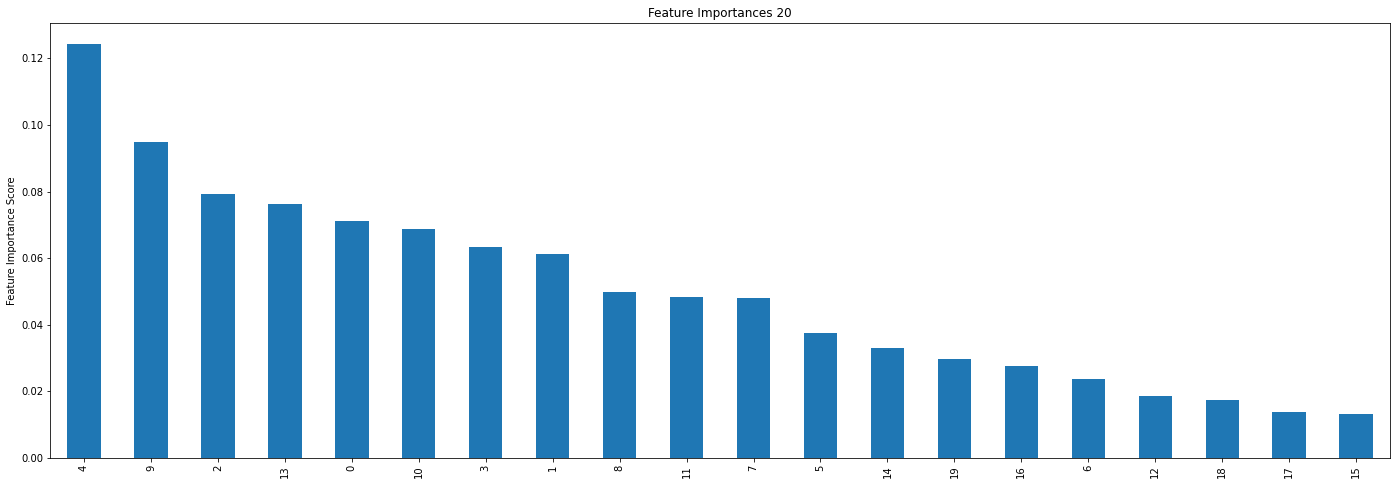

In [ ]:
evaluate(model2)

In [ ]:
 
for (i, j) in enumerate(traindata.columns):
  print(i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 GROUP
5 CALI
6 RSHA
7 RMED
8 RDEP
9 RHOB
10 GR
11 NPHI
12 PEF
13 DTC
14 SP
15 BS
16 ROP
17 DCAL
18 DRHO
19 MUDWEIGHT


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


Default score: [-0.15519935]
Accuracy is: 0.9418055171990549
F1 is: 0.9407185656651175
None
-----------------------FOLD 1---------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DataConvers

building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


Default score: [-0.16152817]
Accuracy is: 0.9393302443564802
F1 is: 0.9379648658035245
None
-----------------------FOLD 2---------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DataConvers

building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


Default score: [-0.15805627]
Accuracy is: 0.9409565599844528
F1 is: 0.939857272986736
None
-----------------------FOLD 3---------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DataConvers

building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


Default score: [-0.15405249]
Accuracy is: 0.9421737396053883
F1 is: 0.9410397762567464
None
-----------------------FOLD 4---------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DataConvers

building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


Default score: [-0.16235156]
Accuracy is: 0.9393455869567441
F1 is: 0.9380697491558598
None
-----------------------FOLD 5---------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------
----------Valid 1-------------
Default score: -0.6742198833525772
Accuracy is: 0.755869378571217
F1 is: 0.7765099091871746
None
----------Valid 2-------------
Default score: -0.9677466943503442
Accuracy is: 0.6239973773358103
F1 is: 0.7120157473243294
None
----------Valid 3-------------
Default score: -0.8207357356578736
Accuracy is: 0.6916734511851733
F1 is: 0.7412065809125525
None


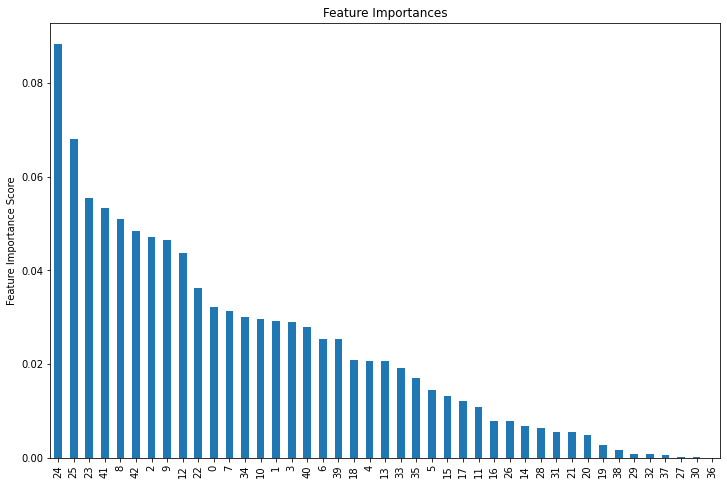

In [ ]:
func1_= Model(traindata, validation1, validation2, validation3, testdata, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
pred1, val1, open_test1, open_test11, model1 = func1_()

In [ ]:
for i,j in enumerate(testdata.columns):
    print(i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DCAL
17 DRHO
18 MUDWEIGHT
19 RMIC
20 ROPA
21 RXO
22 FORMATION_enc
23 GROUP_enc
24 FORMATION_mean_target
25 GROUP_mean_target
26 GROUP_BAAT GP.
27 GROUP_BOKNFJORD GP.
28 GROUP_CROMER KNOLL GP.
29 GROUP_DUNLIN GP.
30 GROUP_HEGRE GP.
31 GROUP_HORDALAND GP.
32 GROUP_NORDLAND GP.
33 GROUP_ROGALAND GP.
34 GROUP_ROTLIEGENDES GP.
35 GROUP_SHETLAND GP.
36 GROUP_TYNE GP.
37 GROUP_VESTLAND GP.
38 GROUP_VIKING GP.
39 GROUP_ZECHSTEIN GP.
40 log_NPHI
41 log_RHOB
42 log_RSHA
43 log_RMED
44 log_RDEP
45 space
46 depth_y
47 density


In [ ]:
print(show_evaluation(pred1, valid1_lithology))
print(show_evaluation(val1, valid2_lithology))
print(show_evaluation(open_test1, valid3_lithology))

Default score: -0.7877586819433342
Accuracy is: 0.7118058639508147
F1 is: 0.736758172169252
None
Default score: -0.9331261610752923
Accuracy is: 0.6366735875860562
F1 is: 0.7061456748458531
None
Default score: -0.8623568120887156
Accuracy is: 0.6753698642923445
F1 is: 0.7222959513287648
None


In [ ]:
open_test11.shape

(136786,)

In [ ]:
class Model():
    
    def __init__(self, train, test, validation1, validation2, validation3, train_label, valid_label):
        
        
        self.train = train
        self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label = valid_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=212)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 5
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      model = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        #model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        pred += model.predict_proba(self.test)
        val1 += model.predict_proba(self.validation1)
        val2 += model.predict_proba(self.validation2)
        val3 += model.predict_proba(self.validation3)
      
      pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

      print(show_evaluation(pred, self.valid_label))
                  
      if plot: self.plot_feat_imp(model)
      return pred, val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.15831
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.741207
[200]	validation_0-mlogloss:0.380388
[300]	validation_0-mlogloss:0.243806
[400]	validation_0-mlogloss:0.186369
[500]	validation_0-mlogloss:0.16036
[600]	validation_0-mlogloss:0.146233
[700]	validation_0-mlogloss:0.137334
[800]	validation_0-mlogloss:0.130712
[900]	validation_0-mlogloss:0.125481
[1000]	validation_0-mlogloss:0.121491
[1100]	validation_0-mlogloss:0.117777
[1200]	validation_0-mlogloss:0.114802
[1300]	validation_0-mlogloss:0.1123
[1400]	validation_0-mlogloss:0.110036
[1500]	validation_0-mlogloss:0.107951
[1600]	validation_0-mlogloss:0.106085
[1700]	validation_0-mlogloss:0.104421
[1800]	validation_0-mlogloss:0.102852
[1900]	validation_0-mlogloss:0.101483
[2000]	validation_0-mlogloss:0.100277
[2100]	validation_0-mlogloss:0.099138
[2200]	validation_0-mlogloss:0.098187
[2300]	validation_0-mlogloss:0.097297
[2400]	validation_0-mlogloss:0.096

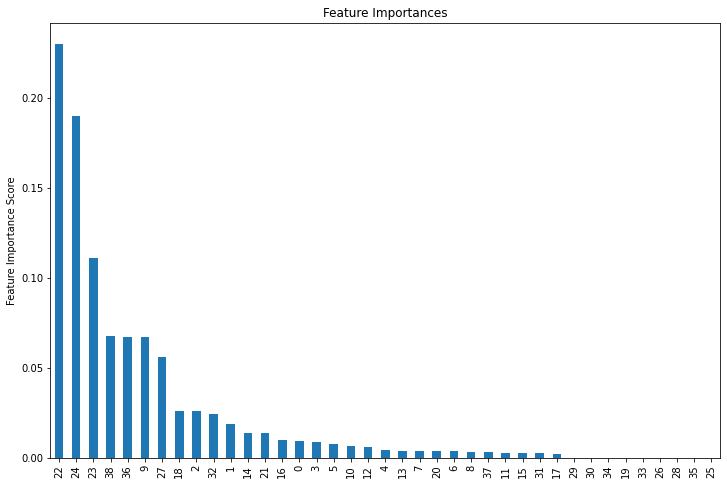

In [ ]:
func1_= Model(train1, validation, validation1, validation2, validation3, ytrain1, valid_target)
pred1, val1, open_test1, open_test11, model1 = func1_()

0:	learn: 2.1606742	test: 2.1606408	best: 2.1606408 (0)	total: 36.5ms	remaining: 1h 47s
100:	learn: 0.2800473	test: 0.2872061	best: 0.2872061 (100)	total: 2.32s	remaining: 38m 11s
200:	learn: 0.2022982	test: 0.2116065	best: 0.2116065 (200)	total: 4.47s	remaining: 37m 1s
300:	learn: 0.1750029	test: 0.1857612	best: 0.1857612 (300)	total: 6.52s	remaining: 35m 59s
400:	learn: 0.1589731	test: 0.1710691	best: 0.1710691 (400)	total: 8.46s	remaining: 35m 2s
500:	learn: 0.1475012	test: 0.1609604	best: 0.1609604 (500)	total: 10.4s	remaining: 34m 25s
600:	learn: 0.1384779	test: 0.1530879	best: 0.1530879 (600)	total: 12.3s	remaining: 33m 59s
700:	learn: 0.1315790	test: 0.1473234	best: 0.1473234 (700)	total: 14.4s	remaining: 33m 56s
800:	learn: 0.1257846	test: 0.1428314	best: 0.1428314 (800)	total: 16.3s	remaining: 33m 39s
900:	learn: 0.1205401	test: 0.1387226	best: 0.1387226 (900)	total: 18.2s	remaining: 33m 26s
1000:	learn: 0.1158765	test: 0.1352435	best: 0.1352435 (1000)	total: 20.3s	remaining: 

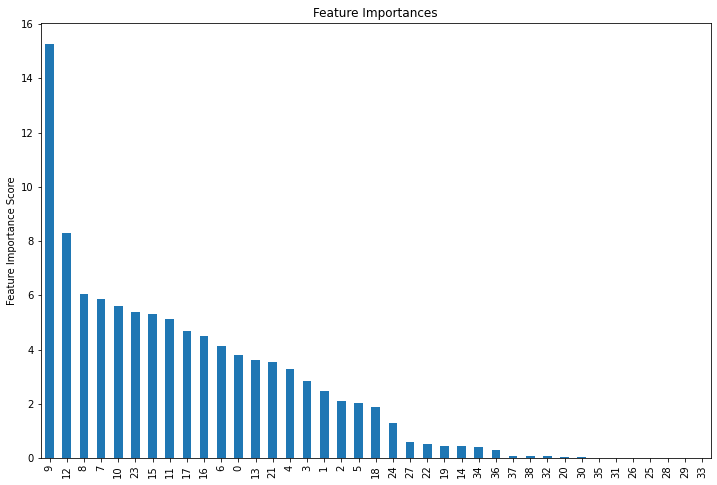

In [ ]:
func2_= Model(train2, validation, validation1, validation2, validation3, ytrain2, valid_target)
pred2, val2, open_test2, open_test22, model2 = func2_()

0:	learn: 2.0952096	test: 2.0960908	best: 2.0960908 (0)	total: 22.9ms	remaining: 38m 10s
100:	learn: 0.3267587	test: 0.3309259	best: 0.3309259 (100)	total: 2.13s	remaining: 35m 9s
200:	learn: 0.2363164	test: 0.2432678	best: 0.2432678 (200)	total: 4.17s	remaining: 34m 29s
300:	learn: 0.2009344	test: 0.2093466	best: 0.2093466 (300)	total: 6.13s	remaining: 33m 51s
400:	learn: 0.1790188	test: 0.1891473	best: 0.1891473 (400)	total: 8.13s	remaining: 33m 40s
500:	learn: 0.1636231	test: 0.1752363	best: 0.1752363 (500)	total: 10.1s	remaining: 33m 26s
600:	learn: 0.1528403	test: 0.1659986	best: 0.1659986 (600)	total: 12s	remaining: 33m 10s
700:	learn: 0.1437725	test: 0.1581308	best: 0.1581308 (700)	total: 14s	remaining: 33m 3s
800:	learn: 0.1358367	test: 0.1513981	best: 0.1513981 (800)	total: 15.9s	remaining: 32m 53s
900:	learn: 0.1292348	test: 0.1460363	best: 0.1460363 (900)	total: 17.9s	remaining: 32m 46s
1000:	learn: 0.1234749	test: 0.1413260	best: 0.1413260 (1000)	total: 19.9s	remaining: 32m

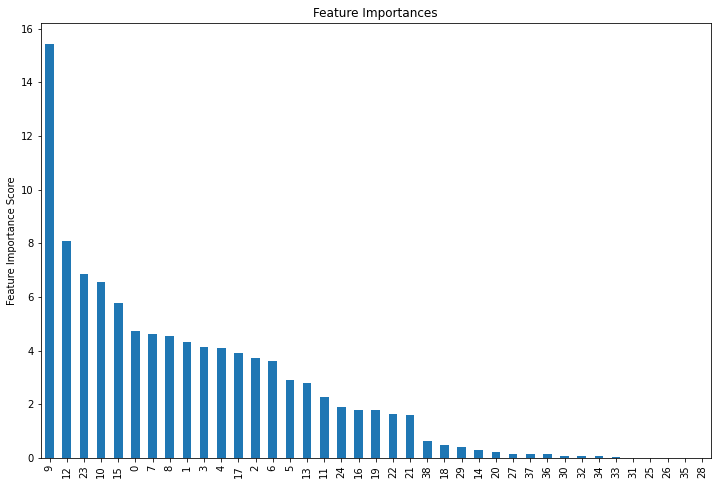

In [ ]:
func3_= Model(train3, validation, validation1, validation2, validation3, ytrain3, valid_target)
pred3, val3, open_test3, open_test33, model3 = func3_()

0:	learn: 2.1041992	test: 2.1040355	best: 2.1040355 (0)	total: 23.9ms	remaining: 39m 53s
100:	learn: 0.3696358	test: 0.3770401	best: 0.3770401 (100)	total: 2.14s	remaining: 35m 17s
200:	learn: 0.2710593	test: 0.2831270	best: 0.2831270 (200)	total: 4.16s	remaining: 34m 25s
300:	learn: 0.2324168	test: 0.2478209	best: 0.2478209 (300)	total: 6.17s	remaining: 34m 5s
400:	learn: 0.2081000	test: 0.2262867	best: 0.2262867 (400)	total: 8.14s	remaining: 33m 41s
500:	learn: 0.1909132	test: 0.2111223	best: 0.2111223 (500)	total: 10.2s	remaining: 33m 38s
600:	learn: 0.1784483	test: 0.2001177	best: 0.2001177 (600)	total: 12.2s	remaining: 33m 34s
700:	learn: 0.1680604	test: 0.1912843	best: 0.1912843 (700)	total: 14.2s	remaining: 33m 32s
800:	learn: 0.1591595	test: 0.1835813	best: 0.1835813 (800)	total: 16.2s	remaining: 33m 27s
900:	learn: 0.1515100	test: 0.1770861	best: 0.1770861 (900)	total: 18.2s	remaining: 33m 20s
1000:	learn: 0.1445060	test: 0.1712729	best: 0.1712729 (1000)	total: 20.2s	remaining

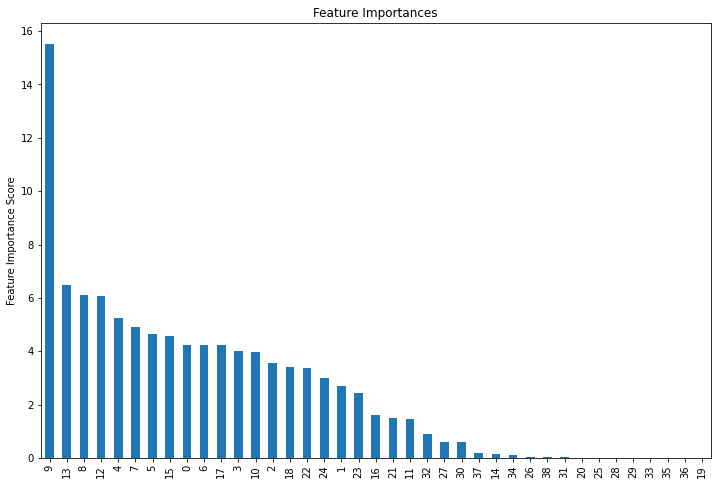

In [ ]:
func4_= Model(train4, validation, validation1, validation2, validation3, ytrain4, valid_target)
pred4, val4, open_test4, open_test44, model4 = func4_()

0:	learn: 1.9313633	test: 1.9318364	best: 1.9318364 (0)	total: 21.7ms	remaining: 36m 13s
100:	learn: 0.3769389	test: 0.3792699	best: 0.3792699 (100)	total: 2.07s	remaining: 34m 5s
200:	learn: 0.2801623	test: 0.2840321	best: 0.2840321 (200)	total: 4.04s	remaining: 33m 24s
300:	learn: 0.2361140	test: 0.2418621	best: 0.2418621 (300)	total: 6.03s	remaining: 33m 17s
400:	learn: 0.2106832	test: 0.2188442	best: 0.2188442 (400)	total: 7.95s	remaining: 32m 53s
500:	learn: 0.1929747	test: 0.2031638	best: 0.2031638 (500)	total: 9.9s	remaining: 32m 46s
600:	learn: 0.1803478	test: 0.1917841	best: 0.1917841 (600)	total: 11.9s	remaining: 32m 43s
700:	learn: 0.1701843	test: 0.1831122	best: 0.1831122 (700)	total: 13.8s	remaining: 32m 36s
800:	learn: 0.1613948	test: 0.1760495	best: 0.1760495 (800)	total: 15.8s	remaining: 32m 34s
900:	learn: 0.1542737	test: 0.1702916	best: 0.1702916 (900)	total: 17.8s	remaining: 32m 33s
1000:	learn: 0.1481595	test: 0.1654668	best: 0.1654668 (1000)	total: 19.7s	remaining:

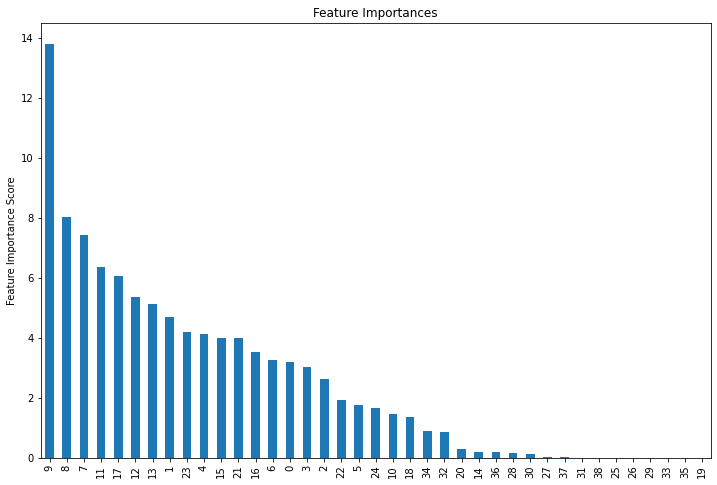

In [ ]:
 func5_= Model(train5, validation, validation1, validation2, validation3, ytrain5, valid_target)
pred5, val5, open_test5, open_test55, model5 = func5_()

0:	learn: 1.9194134	test: 1.9199097	best: 1.9199097 (0)	total: 22ms	remaining: 36m 35s
100:	learn: 0.3098347	test: 0.3196831	best: 0.3196831 (100)	total: 2.09s	remaining: 34m 24s
200:	learn: 0.2229231	test: 0.2341179	best: 0.2341179 (200)	total: 4.01s	remaining: 33m 9s
300:	learn: 0.1882298	test: 0.2007916	best: 0.2007916 (300)	total: 5.96s	remaining: 32m 53s
400:	learn: 0.1680123	test: 0.1814164	best: 0.1814164 (400)	total: 7.87s	remaining: 32m 34s
500:	learn: 0.1534558	test: 0.1678570	best: 0.1678570 (500)	total: 9.81s	remaining: 32m 27s
600:	learn: 0.1420224	test: 0.1574291	best: 0.1574291 (600)	total: 11.7s	remaining: 32m 16s
700:	learn: 0.1330940	test: 0.1495883	best: 0.1495883 (700)	total: 13.6s	remaining: 32m 6s
800:	learn: 0.1258967	test: 0.1433445	best: 0.1433445 (800)	total: 15.5s	remaining: 31m 57s
900:	learn: 0.1197593	test: 0.1383862	best: 0.1383862 (900)	total: 17.3s	remaining: 31m 47s
1000:	learn: 0.1142624	test: 0.1337568	best: 0.1337568 (1000)	total: 19.2s	remaining: 3

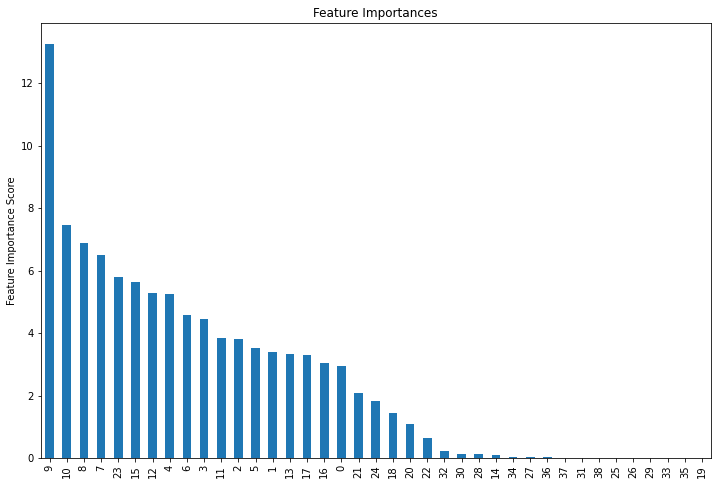

In [ ]:
 func6_= Model(train6, validation, validation1, validation2, validation3, ytrain6, valid_target)
pred6, val6, open_test6, open_test66, model6 = func6_()

0:	learn: 1.9280841	test: 1.9271608	best: 1.9271608 (0)	total: 23ms	remaining: 38m 20s
100:	learn: 0.3337661	test: 0.3377233	best: 0.3377233 (100)	total: 2.09s	remaining: 34m 27s
200:	learn: 0.2395361	test: 0.2464549	best: 0.2464549 (200)	total: 4s	remaining: 33m 5s
300:	learn: 0.2033488	test: 0.2121251	best: 0.2121251 (300)	total: 5.84s	remaining: 32m 15s
400:	learn: 0.1799871	test: 0.1906426	best: 0.1906426 (400)	total: 7.82s	remaining: 32m 21s
500:	learn: 0.1645111	test: 0.1768533	best: 0.1768533 (500)	total: 9.75s	remaining: 32m 16s
600:	learn: 0.1523595	test: 0.1663815	best: 0.1663815 (600)	total: 11.6s	remaining: 32m 4s
700:	learn: 0.1421085	test: 0.1575296	best: 0.1575296 (700)	total: 13.6s	remaining: 32m 4s
800:	learn: 0.1342186	test: 0.1507626	best: 0.1507626 (800)	total: 15.4s	remaining: 31m 52s
900:	learn: 0.1272780	test: 0.1449353	best: 0.1449353 (900)	total: 17.4s	remaining: 31m 50s
1000:	learn: 0.1214205	test: 0.1402397	best: 0.1402397 (1000)	total: 19.3s	remaining: 31m 4

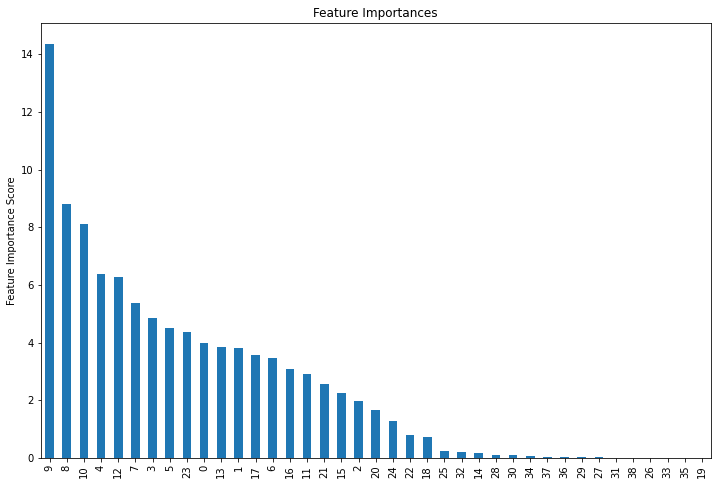

In [ ]:
 func7_= Model(train7, validation, validation1, validation2, validation3, ytrain7, valid_target)
pred7, val7, open_test7, open_test77, model7 = func7_()

0:	learn: 1.9275482	test: 1.9269572	best: 1.9269572 (0)	total: 21.3ms	remaining: 35m 27s
100:	learn: 0.3861259	test: 0.3933957	best: 0.3933957 (100)	total: 1.99s	remaining: 32m 49s
200:	learn: 0.2948859	test: 0.3076861	best: 0.3076861 (200)	total: 3.83s	remaining: 31m 39s
300:	learn: 0.2581253	test: 0.2740162	best: 0.2740162 (300)	total: 5.69s	remaining: 31m 24s
400:	learn: 0.2359545	test: 0.2541672	best: 0.2541672 (400)	total: 7.53s	remaining: 31m 10s
500:	learn: 0.2196904	test: 0.2401568	best: 0.2401568 (500)	total: 9.44s	remaining: 31m 14s
600:	learn: 0.2068412	test: 0.2295719	best: 0.2295719 (600)	total: 11.3s	remaining: 31m 14s
700:	learn: 0.1968803	test: 0.2215413	best: 0.2215413 (700)	total: 13.2s	remaining: 31m 14s
800:	learn: 0.1885379	test: 0.2152397	best: 0.2152397 (800)	total: 15.1s	remaining: 31m 9s
900:	learn: 0.1811973	test: 0.2096961	best: 0.2096961 (900)	total: 17s	remaining: 31m 10s
1000:	learn: 0.1749639	test: 0.2054506	best: 0.2054506 (1000)	total: 18.9s	remaining: 

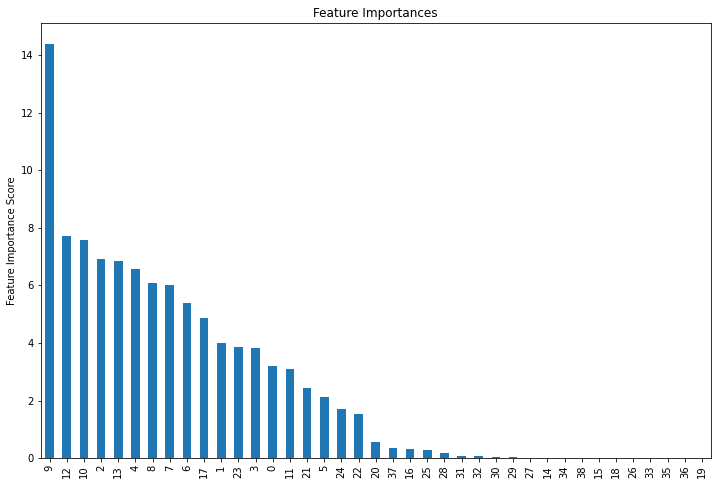

In [ ]:
 func8_= Model(train8, validation, validation1, validation2, validation3, ytrain8, valid_target)
pred8, val8, open_test8, open_test88, model8 = func8_()

0:	learn: 1.9282114	test: 1.9277495	best: 1.9277495 (0)	total: 21.9ms	remaining: 36m 31s
100:	learn: 0.3685634	test: 0.3735366	best: 0.3735366 (100)	total: 2.03s	remaining: 33m 25s
200:	learn: 0.2796261	test: 0.2874189	best: 0.2874189 (200)	total: 3.94s	remaining: 32m 37s
300:	learn: 0.2453294	test: 0.2558422	best: 0.2558422 (300)	total: 5.85s	remaining: 32m 16s
400:	learn: 0.2241662	test: 0.2373415	best: 0.2373415 (400)	total: 7.79s	remaining: 32m 13s
500:	learn: 0.2087560	test: 0.2243363	best: 0.2243363 (500)	total: 9.65s	remaining: 31m 57s
600:	learn: 0.1970257	test: 0.2146476	best: 0.2146476 (600)	total: 11.5s	remaining: 31m 49s
700:	learn: 0.1873548	test: 0.2071115	best: 0.2071115 (700)	total: 13.4s	remaining: 31m 41s
800:	learn: 0.1796599	test: 0.2012661	best: 0.2012661 (800)	total: 15.3s	remaining: 31m 36s
900:	learn: 0.1728183	test: 0.1963169	best: 0.1963169 (900)	total: 17.2s	remaining: 31m 36s
1000:	learn: 0.1663434	test: 0.1915431	best: 0.1915431 (1000)	total: 19.1s	remainin

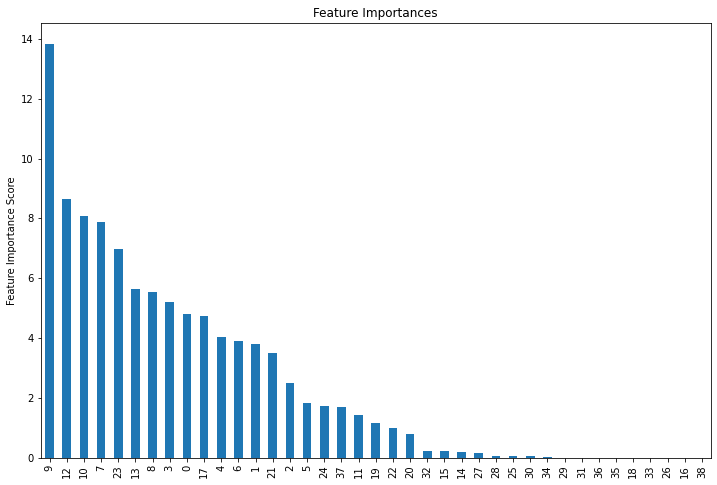

In [ ]:
 func9_= Model(train9, validation, validation1, validation2, validation3, ytrain9, valid_target)
pred9, val9, open_test9, open_test99, model = func9_()

0:	learn: 1.9384189	test: 1.9386618	best: 1.9386618 (0)	total: 37.2ms	remaining: 1h 2m 2s
100:	learn: 0.4087644	test: 0.4168641	best: 0.4168641 (100)	total: 1.99s	remaining: 32m 47s
200:	learn: 0.3267008	test: 0.3362855	best: 0.3362855 (200)	total: 3.8s	remaining: 31m 28s
300:	learn: 0.2943757	test: 0.3050664	best: 0.3050664 (300)	total: 5.62s	remaining: 31m 2s
400:	learn: 0.2717307	test: 0.2839017	best: 0.2839017 (400)	total: 7.43s	remaining: 30m 46s
500:	learn: 0.2560694	test: 0.2695488	best: 0.2695488 (500)	total: 9.2s	remaining: 30m 26s
600:	learn: 0.2443694	test: 0.2593747	best: 0.2593747 (600)	total: 11.1s	remaining: 30m 31s
700:	learn: 0.2343642	test: 0.2509350	best: 0.2509350 (700)	total: 13s	remaining: 30m 36s
800:	learn: 0.2263293	test: 0.2441973	best: 0.2441973 (800)	total: 14.9s	remaining: 30m 41s
900:	learn: 0.2189594	test: 0.2379959	best: 0.2379959 (900)	total: 16.8s	remaining: 30m 43s
1000:	learn: 0.2124375	test: 0.2326755	best: 0.2326755 (1000)	total: 18.7s	remaining: 3

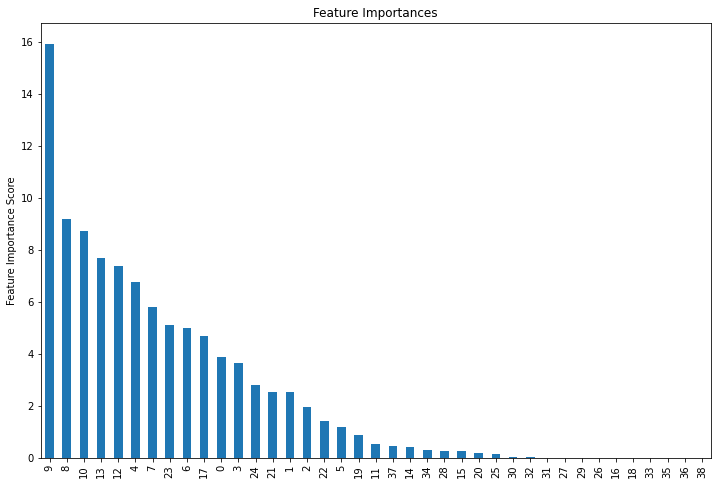

In [ ]:
 func10_= Model(train10, validation, validation1, validation2, validation3, ytrain10, valid_target)
pred10, val10, open_test10, open_test110, model10, = func10_()

In [ ]:
open_test11.shape, open_test22.shape, open_test33.shape, open_test44.shape

((192841,), (192841, 1), (488835,), (488835,))

In [ ]:
stack = np.column_stack((pred1, pred2, pred3))
stack_p = np.column_stack((val1, val2, val3))
stack_open = np.column_stack((open_test1, open_test2, open_test3))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33))

In [ ]:
pd.DataFrame(stack_p).sample(50)

,0,1,2,3
20127,3,3,3,2
78516,2,2,2,2
2578,0,0,0,0
93769,2,2,2,2
63994,5,5,5,5
65896,5,5,5,5
29502,2,2,2,2
34655,2,2,2,2
47083,2,2,2,2
79945,2,2,2,2


In [ ]:
pd.DataFrame(valid1_lithology).tail(50)

,FORCE_2020_LITHOFACIES_LITHOLOGY
101281,2
101282,2
101283,1
101284,1
101285,1
101286,1
101287,1
101288,1
101289,1
101290,1


In [ ]:
valid1_lithology.shape, stack_p.shape

((101331,), (101331, 4))

In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.8023174053349913
Accuracy is: 0.7090525110775577
F1 is: 0.7288841749224375
None
Default score: -0.9325469894000655
Accuracy is: 0.6447929188066878
F1 is: 0.7116844636292764
None
Default score: -0.8641160334161304
Accuracy is: 0.6785590201253883
F1 is: 0.7224786773621489
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.7447659156625317
Accuracy is: 0.731799745388874
F1 is: 0.7519948248511821
None
Default score: -0.9816263249918041
Accuracy is: 0.6241612938476669
F1 is: 0.7062864359599761
None
Default score: -0.8571647108239431
Accuracy is: 0.6807214233487692
F1 is: 0.7289072440608168
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.6792565947242206
Accuracy is: 0.7508561052392654
F1 is: 0.7796947808940052
None
Default score: -0.898985083597421
Accuracy is: 0.639176046333734
F1 is: 0.7126820862055382
None
Default score: -0.7933200149345834
Accuracy is: 0.6951685585534196
F1 is: 0.7464016101794597
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.6880705312293375
Accuracy is: 0.7508857111841392
F1 is: 0.7995730900402213
None
Default score: -0.9892675663861873
Accuracy is: 0.6199759589115944
F1 is: 0.7213657928431049
None
Default score: -0.8456461540854902
Accuracy is: 0.684600266540829
F1 is: 0.7595524241559909
None


In [ ]:
for i,j in enumerate(testdata.columns):
    print(i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DCAL
17 DRHO
18 MUDWEIGHT
19 ROPA
20 RXO
21 FORMATION_enc
22 GROUP_enc
23 FORMATION_mean_target
24 GROUP_mean_target
25 GROUP_BAAT GP.
26 GROUP_BOKNFJORD GP.
27 GROUP_CROMER KNOLL GP.
28 GROUP_DUNLIN GP.
29 GROUP_HEGRE GP.
30 GROUP_HORDALAND GP.
31 GROUP_NORDLAND GP.
32 GROUP_ROGALAND GP.
33 GROUP_ROTLIEGENDES GP.
34 GROUP_SHETLAND GP.
35 GROUP_TYNE GP.
36 GROUP_VESTLAND GP.
37 GROUP_VIKING GP.
38 GROUP_ZECHSTEIN GP.


In [ ]:
train1, sample1, ytrain1, ysample1 = ms.train_test_split(traindata, lithology, random_state=405, test_size=0.875, stratify=lithology)
print(train1.shape, ytrain1.shape, sample1.shape)

(122208, 39) (122208,) (855462, 39)


In [ ]:
train2, sample2, ytrain2, ysample2 = ms.train_test_split(sample1, ysample1, random_state=405, test_size=0.857142857, stratify=ysample1)
print(train2.shape, ytrain2.shape, sample2.shape)

(122208, 39) (122208,) (733254, 39)


In [ ]:
train3, sample3, ytrain3, ysample3 = ms.train_test_split(sample2, ysample2, random_state=405, test_size=0.833333333, stratify=ysample2)
print(train3.shape, ytrain3.shape, sample3.shape)

(122209, 39) (122209,) (611045, 39)


In [ ]:
train4, sample4, ytrain4, ysample4 = ms.train_test_split(sample3, ysample3, random_state=405, test_size=0.8, stratify=ysample3)
print(train4.shape, ytrain4.shape, sample4.shape)

(122209, 39) (122209,) (488836, 39)


In [ ]:
train5, sample5, ytrain5, ysample5 = ms.train_test_split(sample4, ysample4, random_state=405, test_size=0.75, stratify=ysample4)
print(train5.shape, ytrain5.shape, sample5.shape)

(122209, 39) (122209,) (366627, 39)


In [ ]:
train6, sample6, ytrain6, ysample6 = ms.train_test_split(sample5, ysample5, random_state=405, test_size=0.666666667, stratify=ysample5)
print(train6.shape, ytrain6.shape, sample6.shape)

(122208, 39) (122208,) (244419, 39)


In [ ]:
train7, train8, ytrain7, ytrain8 = ms.train_test_split(sample6, ysample6, random_state=405, test_size=0.5, stratify=ysample6)
print(train7.shape, train8.shape, ytrain7.shape, ytrain8.shape)

(122209, 39) (122210, 39) (122209,) (122210,)


In [ ]:
class Model2():
    
    def __init__(self, train, test, validation, train_label, test_label):
        
        
        self.train = train
        self.test = test
        self.validation = validation
        self.train_label = train_label
        self.test_label = test_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):

      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=485)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


      model = CatBoostClassifier(n_estimators=100000, random_state=2020, learning_rate=0.033,
                                  use_best_model=True,
                                  eval_metric='MultiClass', task_type='GPU', verbose=50, reg_lambda=80)
      
      model.fit(self.x_train, self.y_train, early_stopping_rounds=100, eval_set=[(self.x_test, self.y_test)], verbose=50)

      pred = model.predict(self.test)
      val = model.predict(self.validation)
        
 
      print('----------------TEST EVALUATION------------------')
      print(show_evaluation(pred, self.test_label))
                  
      if plot: self.plot_feat_imp(model)
      return pred, val, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
class Model():
    
    def __init__(self, train, test, validation, train_label, test_label):
        
        
        self.train = train
        self.test = test
        self.validation = validation
        self.train_label = train_label
        self.test_label = test_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):

      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=42)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


      model = XGBClassifier(n_estimators=100000, max_depth=6, 
                                 objective='multi:softprob', learning_rate=0.01, 
                            subsample=0.9, tree_method='gpu_hist',
                                 eval_metric='mlogloss')
      
      model.fit(self.x_train, self.y_train, early_stopping_rounds=100, eval_set=[(self.x_test, self.y_test)], verbose=300)

      pred = model.predict(self.test)
      val = model.predict(self.validation)
        
 
      print('----------------TEST EVALUATION------------------')
      print(show_evaluation(pred, self.test_label))
                  
      if plot: self.plot_feat_imp(model)
      return pred, val, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
class Model():
    
    def __init__(self, train, test, validation, train_label, test_label):
        
        
        self.train = train
        self.test = test
        self.validation = validation
        self.train_label = train_label
        self.test_label = test_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


      model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      model.fit(self.train, self.train_label)

      pred = model.predict(self.test)
      val = model.predict(self.validation)
        
 
      print('----------------TEST EVALUATION------------------')
      print(show_evaluation(pred, self.test_label))
                  
      if plot: self.plot_feat_imp(model)
      return pred, val, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
func1_= Model(train1, validation1, validation2, ytrain1, valid1_lithology)
pred1, val1, model1 = func1_()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.44432
Will train until validation_0-mlogloss hasn't improved in 100 rounds.


KeyboardInterrupt: ignored

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.7252778024493985
Accuracy is: 0.7394479478145878
F1 is: 0.7901025777140493
None


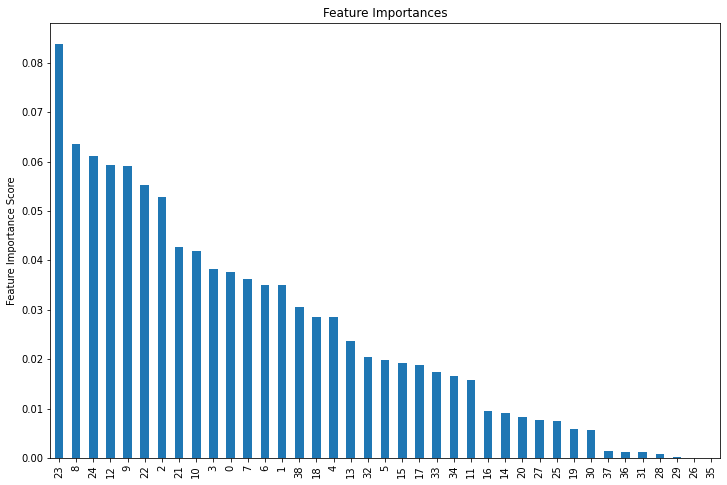

In [ ]:
func2_= Model(train2, validation1, validation2, ytrain2, valid1_lithology)
pred2, val2, model2 = func2_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.6948453582812762
Accuracy is: 0.7521587668137095
F1 is: 0.7884052305212116
None


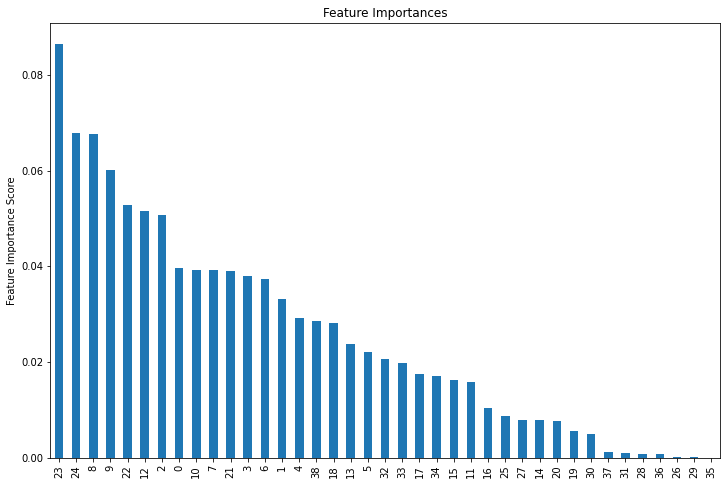

In [ ]:
func3_= Model(train3, validation1, validation2, ytrain3, valid1_lithology)
pred3, val3, model3 = func3_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.7137758928659541
Accuracy is: 0.7437802844144438
F1 is: 0.7867610319012607
None


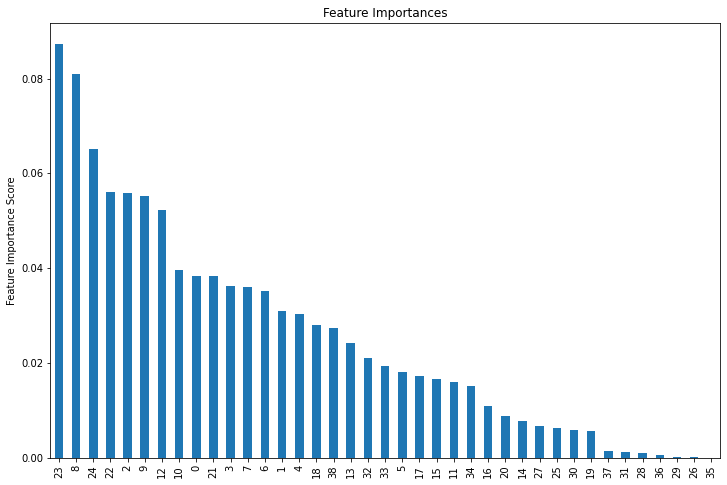

In [ ]:
func4_= Model(train4, validation1, validation2, ytrain4, valid1_lithology)
pred4, val4, model4 = func4_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.6811809811410131
Accuracy is: 0.7508067619978092
F1 is: 0.8016087632022063
None


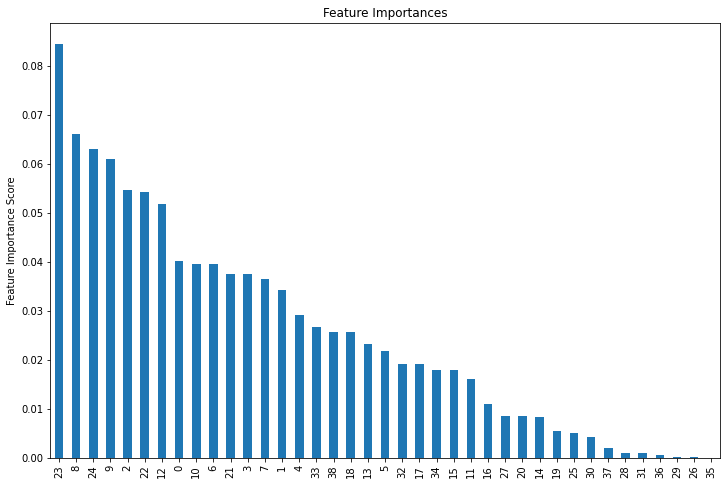

In [ ]:
func5_= Model(train5, validation1, validation2, ytrain5, valid1_lithology)
pred5, val5, model5 = func5_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.665167865707434
Accuracy is: 0.7588497103551727
F1 is: 0.8024738748980553
None


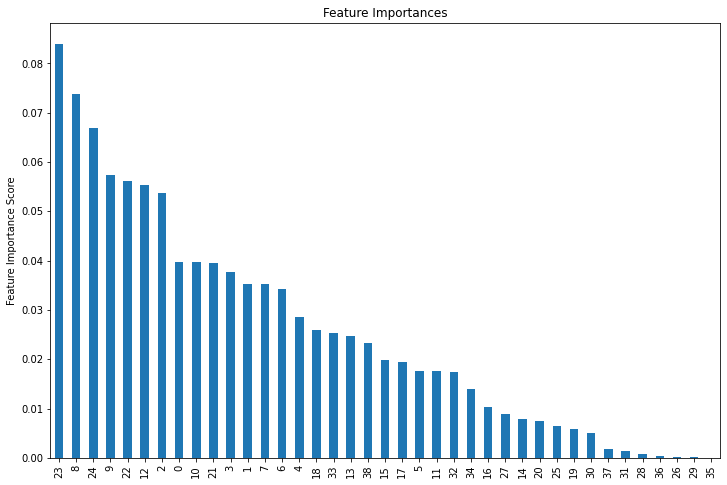

In [ ]:
func6_= Model(train6, validation1, validation2, ytrain6, valid1_lithology)
pred6, val6, model6 = func6_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.6933132506340607
Accuracy is: 0.7504613593076156
F1 is: 0.79322607638325
None


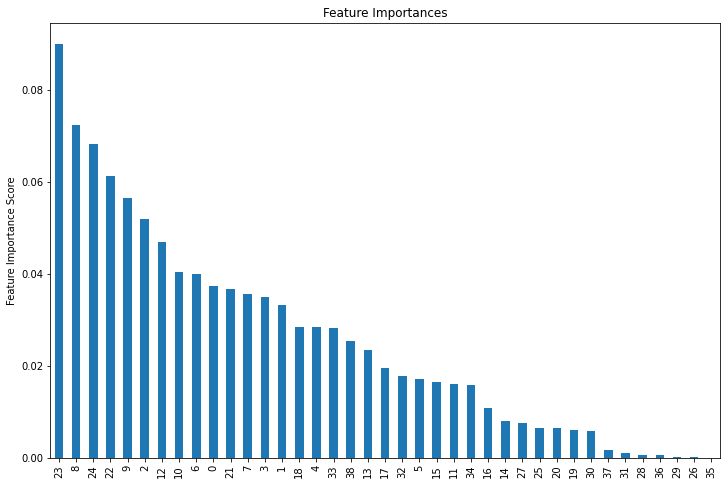

In [ ]:
func7_= Model(train7, validation1, validation2, ytrain7, valid1_lithology)
pred7, val7, model7 = func7_()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


----------------TEST EVALUATION------------------
Default score: -0.7006148167885444
Accuracy is: 0.7468395653847293
F1 is: 0.7957151697649927
None


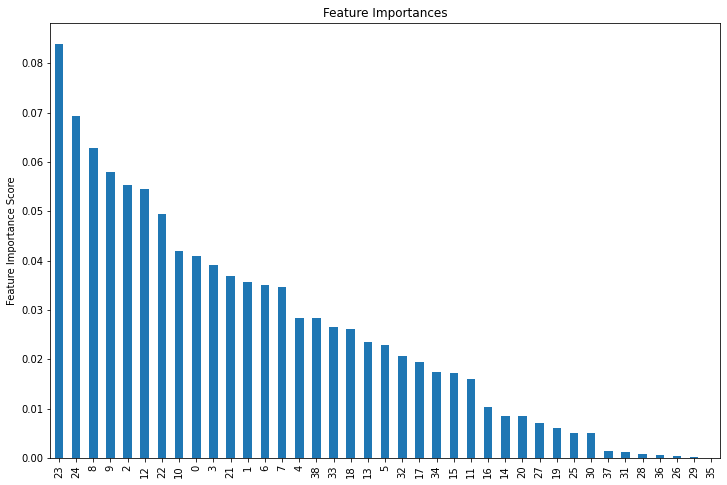

In [ ]:
func8_= Model(train8, validation1, validation2, ytrain8, valid1_lithology)
pred8, val8, model8 = func8_()

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred11, pred22))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8, val11, val22))

In [ ]:
stack = np.column_stack((pred1, pred2, pred11, pred22))
stack_p = np.column_stack((val1, val2, val11, val22))

In [ ]:
#meta_model = LogisticRegression()
meta_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', verbose=2)
meta_model.fit(stack, valid1_lithology)
final_pred = meta_model.predict(stack_p)
 
print(show_evaluation(final_pred, valid2_lithology))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Default score: -0.996609660146432
Accuracy is: 0.6154737187192657
F1 is: 0.6671234635157725
None


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.6s finished


In [ ]:
print(final_pred[1000:1120])
print(list(valid2_lithology[1000:1200]))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
make_submission(val1, 'open_test1_pred1')
 
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/open_test1_pred1.csv')
 
a['# lithology'].value_counts()

65000    75739
30000    15826
70000     7474
65030     1142
90000      570
99000      302
80000      278
Name: # lithology, dtype: int64

In [ ]:
valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    58959
30000    17968
65030    12800
70000     7348
80000     2693
90000      795
99000      619
74000      149
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.shape, a.shape

((114079,), (114079, 1))

In [ ]:
make_submission(open_test1, 'open_test1_pred2')
 
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/open_test1_pred2.csv')
 
a['# lithology'].value_counts()

65000    76757
30000    10745
70000     2460
99000     1082
65030      340
90000      126
Name: # lithology, dtype: int64

In [ ]:
valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    44709
65030    21727
30000    15022
80000     4400
70000     3624
99000     1812
90000      131
74000       80
86000        5
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64